In [30]:
# @title Load the imports

import io
import keras
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
import ml_edu.experiment
import ml_edu.results
import numpy as np
import pandas as pd
import plotly.express as px

# The following lines adjust the granularity of reporting.
pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format

print("Ran the import statements.")

Ran the import statements.


In [31]:
rice_dataset_raw = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/Rice_Cammeo_Osmancik.csv")

In [32]:
# Display basic statistics of the dataset
rice_dataset=rice_dataset_raw
rice_dataset_raw.describe(include='all')

,Area,Perimeter,Major_Axis_Length,Minor_Axis_Length,Eccentricity,Convex_Area,Extent,Class
count,3810.0,3810.0,3810.0,3810.0,3810.0,3810.0,3810.0,3810
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Osmancik
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2180
mean,12667.7,454.2,188.8,86.3,0.9,12952.5,0.7,NaN
...,...,...,...,...,...,...,...,...
min,7551.0,359.1,145.3,59.5,0.8,7723.0,0.5,NaN
25%,11370.5,426.1,174.4,82.7,0.9,11626.2,0.6,NaN
50%,12421.5,448.9,185.8,86.4,0.9,12706.5,0.6,NaN
75%,13950.0,483.7,203.6,90.1,0.9,14284.0,0.7,NaN


In [33]:
# @title Solutions (run the cell to get the answers)

print(
    f'The shortest grain is {rice_dataset.Major_Axis_Length.min():.1f}px long,'
    f' while the longest is {rice_dataset.Major_Axis_Length.max():.1f}px.'
)
print(
    f'The smallest rice grain has an area of {rice_dataset.Area.min()}px, while'
    f' the largest has an area of {rice_dataset.Area.max()}px.'
)
print(
    'The largest rice grain, with a perimeter of'
    f' {rice_dataset.Perimeter.max():.1f}px, is'
    f' ~{(rice_dataset.Perimeter.max() - rice_dataset.Perimeter.mean())/rice_dataset.Perimeter.std():.1f} standard'
    f' deviations ({rice_dataset.Perimeter.std():.1f}) from the mean'
    f' ({rice_dataset.Perimeter.mean():.1f}px).'
)
print(
    f'This is calculated as: ({rice_dataset.Perimeter.max():.1f} -'
    f' {rice_dataset.Perimeter.mean():.1f})/{rice_dataset.Perimeter.std():.1f} ='
    f' {(rice_dataset.Perimeter.max() - rice_dataset.Perimeter.mean())/rice_dataset.Perimeter.std():.1f}'
)

The shortest grain is 145.3px long, while the longest is 239.0px.
The smallest rice grain has an area of 7551px, while the largest has an area of 18913px.
The largest rice grain, with a perimeter of 548.4px, is ~2.6 standard deviations (35.6) from the mean (454.2px).
This is calculated as: (548.4 - 454.2)/35.6 = 2.6


In [34]:
# Create five 2D plots of the features against each other, color-coded by class.
for x_axis_data, y_axis_data in [
    ('Area', 'Eccentricity'),
    ('Convex_Area', 'Perimeter'),
    ('Major_Axis_Length', 'Minor_Axis_Length'),
    ('Perimeter', 'Extent'),
    ('Eccentricity', 'Major_Axis_Length'),
]:
  px.scatter(rice_dataset, x=x_axis_data, y=y_axis_data, color='Class').show()

In [35]:
fig_3d = px.scatter_3d(
    rice_dataset,
    x='Eccentricity',
    y='Area',
    z='Major_Axis_Length',
    color='Class',
    opacity=0.7,
    title='3D Scatter: Eccentricity, Area, Major Axis Length'
)
fig_3d.show()

In [36]:
# Calculate the Z-scores of each numerical column in the raw data and write
# them into a new DataFrame named df_norm.

feature_mean = rice_dataset.mean(numeric_only=True)
feature_std = rice_dataset.std(numeric_only=True)
numerical_features = rice_dataset.select_dtypes('number').columns
normalized_dataset = (
    rice_dataset[numerical_features] - feature_mean
) / feature_std

# Copy the class to the new dataframe
normalized_dataset['Class'] = rice_dataset['Class']

# Examine some of the values of the normalized training set. Notice that most
# Z-scores fall between -2 and +2.
print(normalized_dataset.head())
print(rice_dataset.head())

   Area  Perimeter  Major_Axis_Length  Minor_Axis_Length  Eccentricity  \
0   1.5        2.0                2.3               -0.2           2.0   
1   1.1        1.1                1.0                0.9           0.4   
2   1.1        1.3                1.5                0.3           1.2   
3   0.3        0.1                0.3                0.2           0.2   
4   1.2        1.5                1.3                0.5           1.0   

   Convex_Area  Extent   Class  
0          1.5    -1.2  Cammeo  
1          1.2    -0.6  Cammeo  
2          1.1     0.4  Cammeo  
3          0.2    -0.3  Cammeo  
4          1.3    -0.2  Cammeo  
    Area  Perimeter  Major_Axis_Length  Minor_Axis_Length  Eccentricity  \
0  15231      525.6              229.7               85.1           0.9   
1  14656      494.3              206.0               91.7           0.9   
2  14634      501.1              214.1               87.8           0.9   
3  13176      458.3              193.3               87.4

In [37]:
keras.utils.set_random_seed(42)


In [38]:
# Create a column setting the Cammeo label to '1' and the Osmancik label to '0'
# then show 10 randomly selected rows.
normalized_dataset['Class_Bool'] = (
    # Returns true if class is Cammeo, and false if class is Osmancik
    normalized_dataset['Class'] == 'Cammeo'
).astype(int)
normalized_dataset.sample(10)

,Area,Perimeter,Major_Axis_Length,Minor_Axis_Length,Eccentricity,Convex_Area,Extent,Class,Class_Bool
1011,-0.1,0.1,-0.1,0.2,-0.1,-0.0,-1.0,Cammeo,1
3185,-0.1,-0.5,-0.5,0.4,-0.8,-0.2,-0.3,Osmancik,0
3698,0.1,-0.1,-0.4,0.9,-1.1,0.1,-0.2,Osmancik,0
897,0.2,0.5,0.8,-0.5,1.2,0.2,1.5,Cammeo,1
3245,-1.3,-1.3,-0.9,-1.6,0.5,-1.4,-1.1,Osmancik,0
478,0.2,0.2,0.4,-0.0,0.5,0.2,1.7,Cammeo,1
1731,-0.4,-0.8,-0.8,0.3,-1.0,-0.5,-0.4,Osmancik,0
1025,0.6,0.7,0.6,0.3,0.5,0.6,-0.5,Cammeo,1
429,1.2,1.2,1.4,0.6,1.0,1.2,1.8,Cammeo,1
1330,-0.4,-0.0,0.4,-1.3,1.4,-0.5,-0.1,Cammeo,1


In [40]:
# Create indices at the 80th and 90th percentiles
number_samples = len(normalized_dataset)
index_80th = round(number_samples * 0.8)
index_90th = index_80th + round(number_samples * 0.1)

# Randomize order and split into train, validation, and test with a .8, .1, .1 split
shuffled_dataset = normalized_dataset.sample(frac=1, random_state=100)
train_data = shuffled_dataset.iloc[0:index_80th]
validation_data = shuffled_dataset.iloc[index_80th:index_90th]
test_data = shuffled_dataset.iloc[index_90th:]

train_data.head(), validation_data.head(), test_data.head()

(      Area  Perimeter  Major_Axis_Length  Minor_Axis_Length  Eccentricity  \
 2030  -2.1       -2.2               -1.8               -2.1          -0.3   
 2225  -0.6       -0.3               -0.5               -0.4          -0.1   
 1053   0.7        1.2                1.4               -0.4           1.5   
 3685  -0.2       -0.1               -0.3                0.1          -0.3   
 2976  -0.7       -0.9               -1.2                0.4          -1.7   
 
       Convex_Area  Extent     Class  Class_Bool  
 2030         -2.1     1.0  Osmancik           0  
 2225         -0.5    -0.9  Osmancik           0  
 1053          0.8    -1.7    Cammeo           1  
 3685         -0.2    -0.8  Osmancik           0  
 2976         -0.7     0.6  Osmancik           0  ,
       Area  Perimeter  Major_Axis_Length  Minor_Axis_Length  Eccentricity  \
 640    0.9        0.8                0.6                1.1          -0.1   
 966    0.8        0.9                1.1                0.1       

In [41]:
label_columns = ['Class', 'Class_Bool']

train_features = train_data.drop(columns=label_columns)
train_labels = train_data['Class_Bool'].to_numpy()
validation_features = validation_data.drop(columns=label_columns)
validation_labels = validation_data['Class_Bool'].to_numpy()
test_features = test_data.drop(columns=label_columns)
test_labels = test_data['Class_Bool'].to_numpy()

In [42]:
# Name of the features we'll train our model on.
input_features = [
    'Eccentricity',
    'Major_Axis_Length',
    'Area',
]

In [43]:
# @title Define the functions that create and train a model.


def create_model(
    settings: ml_edu.experiment.ExperimentSettings,
    metrics: list[keras.metrics.Metric],
) -> keras.Model:
  """Create and compile a simple classification model."""
  model_inputs = [
      keras.Input(name=feature, shape=(1,))
      for feature in settings.input_features
  ]
  # Use a Concatenate layer to assemble the different inputs into a single
  # tensor which will be given as input to the Dense layer.
  # For example: [input_1[0][0], input_2[0][0]]

  concatenated_inputs = keras.layers.Concatenate()(model_inputs)
  model_output = keras.layers.Dense(
      units=1, name='dense_layer', activation=keras.activations.sigmoid
  )(concatenated_inputs)
  model = keras.Model(inputs=model_inputs, outputs=model_output)
  # Call the compile method to transform the layers into a model that
  # Keras can execute.  Notice that we're using a different loss
  # function for classification than for regression.
  model.compile(
      optimizer=keras.optimizers.RMSprop(
          settings.learning_rate
      ),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics,
  )
  return model


def train_model(
    experiment_name: str,
    model: keras.Model,
    dataset: pd.DataFrame,
    labels: np.ndarray,
    settings: ml_edu.experiment.ExperimentSettings,
) -> ml_edu.experiment.Experiment:
  """Feed a dataset into the model in order to train it."""

  # The x parameter of keras.Model.fit can be a list of arrays, where
  # each array contains the data for one feature.
  features = {
      feature_name: np.array(dataset[feature_name])
      for feature_name in settings.input_features
  }

  history = model.fit(
      x=features,
      y=labels,
      batch_size=settings.batch_size,
      epochs=settings.number_epochs,
  )

  return ml_edu.experiment.Experiment(
      name=experiment_name,
      settings=settings,
      model=model,
      epochs=history.epoch,
      metrics_history=pd.DataFrame(history.history),
  )


print('Defined the create_model and train_model functions.')

Defined the create_model and train_model functions.


Epoch 1/60
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6879 - auc: 0.8524 - loss: 0.5124 - precision: 0.5897 - recall: 0.9565
Epoch 2/60
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7115 - auc: 0.8697 - loss: 0.4899 - precision: 0.6103 - recall: 0.9537
Epoch 3/60
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7330 - auc: 0.8822 - loss: 0.4712 - precision: 0.6293 - recall: 0.9575
Epoch 4/60
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7512 - auc: 0.8931 - loss: 0.4537 - precision: 0.6473 - recall: 0.9551
Epoch 5/60
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7643 - auc: 0.9022 - loss: 0.4373 - precision: 0.6606 - recall: 0.9553
Epoch 6/60
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7727 - auc: 0.9105 - loss: 0.4220 - precision: 0.6698 - recall: 0.9533
Epoch 7/60
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7829 - auc: 0.9176 - loss: 0.4076 - precision: 0.6812 - recall: 0.9521
Epoch 8/60
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - acc

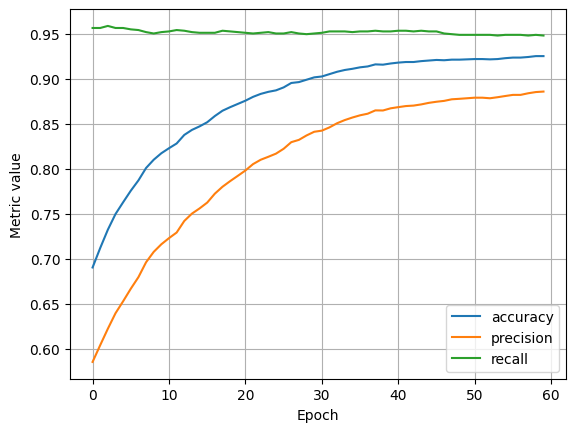

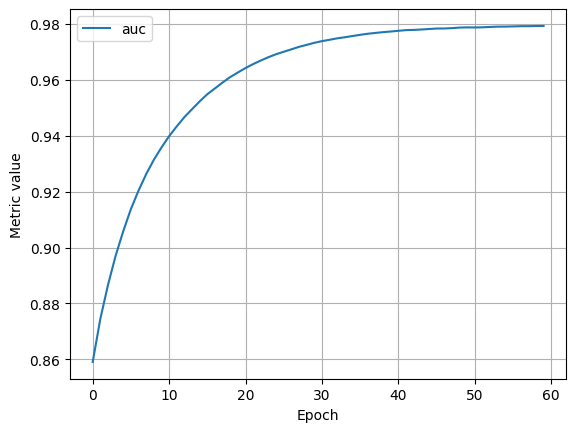

In [44]:
# Let's define our first experiment settings.
settings = ml_edu.experiment.ExperimentSettings(
    learning_rate=0.001,
    number_epochs=60,
    batch_size=100,
    classification_threshold=0.35,
    input_features=input_features,
)

metrics = [
    keras.metrics.BinaryAccuracy(
        name='accuracy', threshold=settings.classification_threshold
    ),
    keras.metrics.Precision(
        name='precision', thresholds=settings.classification_threshold
    ),
    keras.metrics.Recall(
        name='recall', thresholds=settings.classification_threshold
    ),
    keras.metrics.AUC(num_thresholds=100, name='auc'),
]

# Establish the model's topography.
model = create_model(settings, metrics)

# Train the model on the training set.
experiment = train_model(
    'baseline', model, train_features, train_labels, settings
)

# Plot metrics vs. epochs
ml_edu.results.plot_experiment_metrics(experiment, ['accuracy', 'precision', 'recall'])
ml_edu.results.plot_experiment_metrics(experiment, ['auc'])

In [45]:
def compare_train_test(experiment: ml_edu.experiment.Experiment, test_metrics: dict[str, float]):
  print('Comparing metrics between train and test:')
  for metric, test_value in test_metrics.items():
    print('------')
    print(f'Train {metric}: {experiment.get_final_metric_value(metric):.4f}')
    print(f'Test {metric}:  {test_value:.4f}')


# Evaluate test metrics
test_metrics = experiment.evaluate(test_features, test_labels)
compare_train_test(experiment, test_metrics)

Comparing metrics between train and test:
------
Train accuracy: 0.9252
Test accuracy:  0.9081
------
Train auc: 0.9793
Test auc:  0.9752
------
Train loss: 0.1844
Test loss:  0.1959
------
Train precision: 0.8858
Test precision:  0.8545
------
Train recall: 0.9481
Test recall:  0.9276
